## Exercício 2 de Análise de Componentes Independentes


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.cluster.vq import whiten
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy.stats import entropy, chi2_contingency, shapiro
%matplotlib inline

#Notes:
#SHAPIRO: The algorithm used is described in [R634] but censoring parameters as 
#        described are not implemented. For N > 5000 the W test statistic is 
#        accurate but the p-value may not be.

In [2]:
def g(y):
    return np.multiply(np.power(y,2),np.sign(y))
    #return np.tanh(10*y)

def f(y):
    return np.power(y,3)

def NPCA_RLS(mixtures, learning_rate):
    P = np.identity(mixtures.shape[0])
    W = np.identity(mixtures.shape[0])
    y = np.zeros(mixtures.shape)
    beta = 0.9
    whitenedMixtures = whiten(mixtures)
    
    for i in np.arange(whitenedMixtures.shape[1]):
        y[:,i] = np.dot(W, whitenedMixtures[:,i])
        z = np.reshape(g(y[:,i]), (mixtures.shape[0], 1))
        h = np.dot(P,z)
        m = h/(beta + np.dot(np.transpose(z),h))

        Triangle = P - np.dot(m, np.transpose(h))
        lowerIndices = np.tril_indices(whitenedMixtures.shape[0])
        Triangle[lowerIndices] = Triangle.T[lowerIndices]

        P = (1/beta) * Triangle
        e =  np.reshape(whitenedMixtures[:,i], (whitenedMixtures.shape[0], 1)) - np.dot(np.transpose(W),z)

        W = W + np.dot(m,np.transpose(e))

    return y, W

def cichocki_Feedforward(mixtures, learning_rate):
    # FeedFoward
    I = np.identity(mixtures.shape[0])
    W = I
    y = np.zeros(mixtures.shape)
    dW = np.ones(W.shape) - I
    
    whitenedMixtures = whiten(mixtures)

    for i in np.arange(mixtures.shape[1]):
        input_ = np.reshape(whitenedMixtures[:,i], (mixtures.shape[0], 1))

        y[:,i] = np.reshape(np.dot(W, input_), (mixtures.shape[0],))
        gY = np.reshape(g(y[:,i]), (mixtures.shape[0],1))
        fY = np.reshape(f(y[:,i]), (mixtures.shape[0],1))
        
        dW = np.dot(I-np.dot(fY,np.transpose(gY)),W)
        W = W + learning_rate*dW
        if (np.isnan(W).any() == True):
            print('Lost convergence at iterator %d'%i)
            break
    return y, W

def cichocki_Feedback(mixtures, learning_rate):
    # Feedback
    I = np.identity(mixtures.shape[0])
    W = np.zeros((mixtures.shape[0], mixtures.shape[0]))
    y = np.zeros(mixtures.shape)
    dW = np.ones(W.shape) - I
   
    whitenedMixtures = whiten(mixtures)


    for i in np.arange(mixtures.shape[1]):
        inversa = inv(I+W)
        input_ = np.reshape(whitenedMixtures[:,i], (mixtures.shape[0], 1))

        y[:,i] = np.reshape(np.dot(inversa, input_), (mixtures.shape[0],))
        gY = np.reshape(g(y[:,i]), (mixtures.shape[0],1))
        fY = np.reshape(f(y[:,i]), (mixtures.shape[0],1))
        
        dW = np.dot((I+W),I-np.dot(fY,np.transpose(gY)))
        W = W - learning_rate*dW
        
        if (np.isnan(W).any() == True):
            print('Lost convergence at iterator %d'%i)
            break
    return y, W

def kde_entropy(x, bandwidth = 'silverman', **kwargs):
    from statsmodels.nonparametric.kde import KDEUnivariate
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(np.reshape(x, (-1,1)))
    kde.fit(bw = bandwidth, kernel = 'gau', fft = True, **kwargs)
    
    return kde.entropy

def calculateNegentropy(x, kindOfNegentropy = 'empirical'):
    
    if kindOfNegentropy == 'KDE':
        return np.log(np.std(x)*np.sqrt(2*np.pi*np.exp(1))) - kde_entropy(x)
    elif kindOfNegentropy == 'empirical':
        gaussian_hist = np.histogram(np.random.normal(loc=np.mean(x), scale=np.std(x), size = 1000), bins = 100)[0]
        x_hist = np.histogram(x, bins = 100)[0]
        return entropy(gaussian_hist) - entropy(x_hist)
    else:
        print('Not implemented')
        return None
    
def resultsTable(y):
    import tabulate
    from IPython.display import HTML, display
    
    data = np.array([["Data", "Negentropy Test", "Shapiro-Wilk test W", "Shapiro-Wilk test P_value"]])
    for i, y_i in enumerate(y):
        shapiro_yi = shapiro(y_i)
        new_row = np.array([["%d"%i, "%.04f"%calculateNegentropy(y_i), "%.04f"%shapiro_yi[0], "%.04E"%shapiro_yi[1]]])
        data = np.concatenate((data, new_row))
    display(HTML(tabulate.tabulate(data, tablefmt = 'html', headers = 'firstrow')))
    return None

In [3]:
learning_rate = 1e-6
gaussian_distribution = np.random.normal(0,1,1000)
shapiro(np.random.uniform(-1,1,1000))

(0.9550114274024963, 5.916592634509272e-17)

In [4]:
filePath = 'https://raw.githubusercontent.com/micaelverissimo/ICA/master/SecondMixture1000Stats.txt'
distDataFrame = pd.read_table(filePath, delimiter = '\s+', header = None)
mixtures = distDataFrame.values
print(distDataFrame.T.head())

          0         1         2
0 -0.269118 -0.858271 -2.186817
1 -1.772794  1.377290 -4.480604
2  2.789870  1.677561  0.328043
3 -0.031164 -2.212707  4.467393
4  2.257872 -2.854968  2.076838


In [5]:
#h, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize = (10,10))
#ax1.plot(distDataFrame.values[0])
#ax2.plot(distDataFrame.values[1])
#ax3.plot(distDataFrame.values[2])
#plt.show()

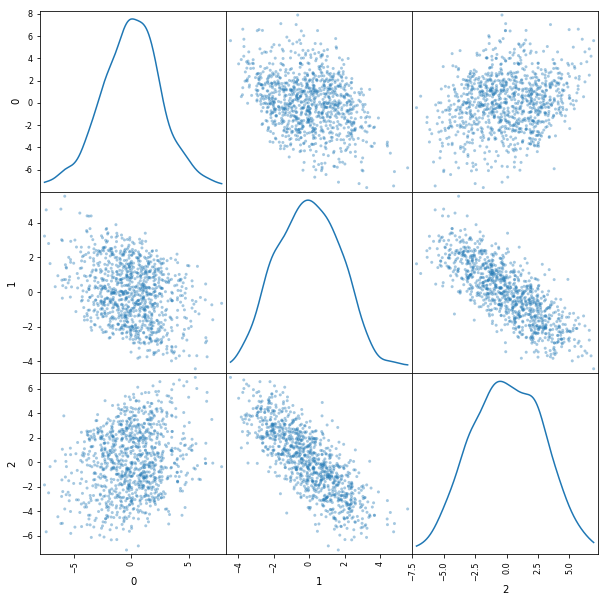

In [6]:
#scatter_hist(distDataFrame.values[0], distDataFrame.values[1], distDataFrame.values[2])
scatter_matrix(distDataFrame.T, alpha=0.4, diagonal = 'kde', figsize = (10,10))
plt.show()

In [7]:
resultsTable(mixtures)

Data,Negentropy Test,Shapiro-Wilk test W,Shapiro-Wilk test P_value
0,-0.0572,0.998,0.29041
1,-0.1287,0.9939,0.00042956
2,-0.202,0.9938,0.00037468


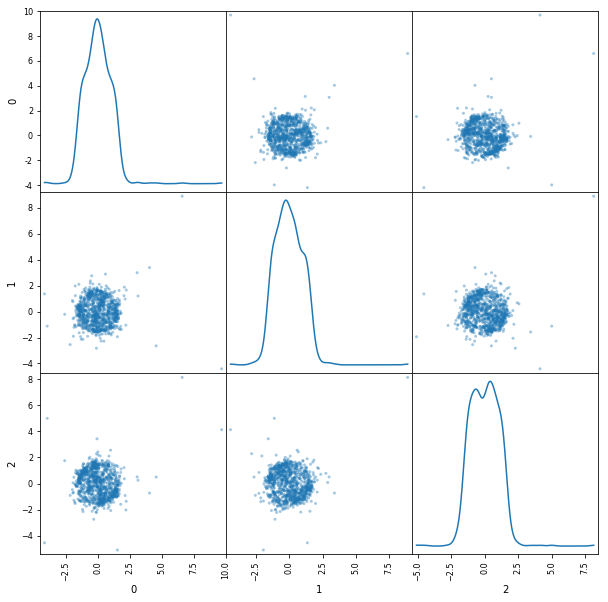

In [8]:
[y, W] = NPCA_RLS(mixtures, 1e-6)
scatter_matrix(pd.DataFrame(y.T), alpha = 0.4, diagonal = 'kde', figsize = (10,10))
plt.show()
#pd.DataFrame(y.T).describe()

In [9]:
resultsTable(y)

Data,Negentropy Test,Shapiro-Wilk test W,Shapiro-Wilk test P_value
0,0.7668,0.9328,8.6756e-21
1,0.7041,0.96,6.6025e-16
2,0.7313,0.9564,1.1249e-16


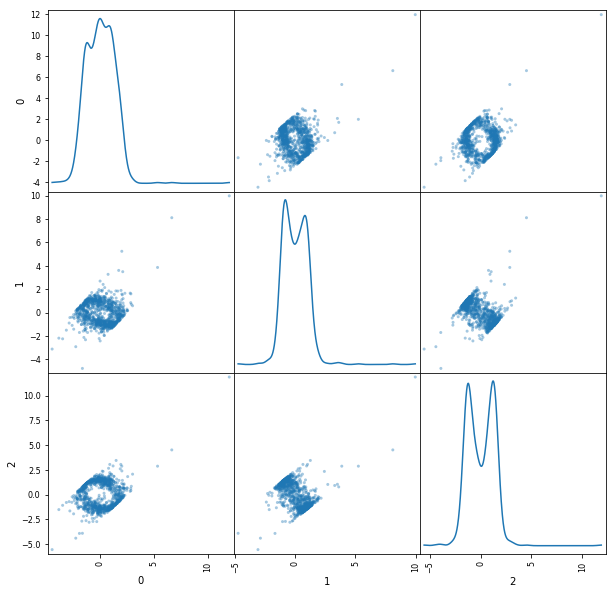

In [10]:
[y, W] = cichocki_Feedback(mixtures, learning_rate)
scatter_matrix(pd.DataFrame(y.T), alpha = 0.4, diagonal = 'kde', figsize = (10,10))
plt.show()

In [11]:
resultsTable(y)

Data,Negentropy Test,Shapiro-Wilk test W,Shapiro-Wilk test P_value
0,0.7831,0.9473,2.0727e-18
1,1.0458,0.8989,3.904e-25
2,0.887,0.9185,8.5844e-23


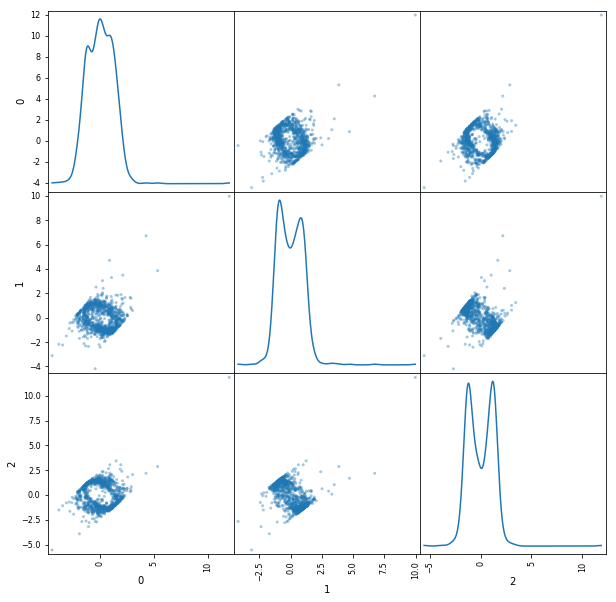

In [12]:
[y, W] = cichocki_Feedforward(mixtures, learning_rate)
scatter_matrix(pd.DataFrame(y.T), alpha = 0.4, diagonal = 'kde', figsize = (10,10))
plt.show()

In [13]:
resultsTable(y)

Data,Negentropy Test,Shapiro-Wilk test W,Shapiro-Wilk test P_value
0,0.8046,0.9491,4.3387e-18
1,0.8337,0.913,1.7332e-23
2,1.0238,0.913,1.7409e-23
